<a href="https://colab.research.google.com/github/mc-cat-tty/PlaceRank/blob/BERTembeddings/finetuneBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### finetuning BERT for sentiment analysis

In [1]:
import os
import re
import string
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
file1_path = '/content/drive/MyDrive/Colab Notebooks/inputs/nyc_listings.csv'
file2_path = '/content/drive/MyDrive/Colab Notebooks/inputs/nyc_reviews.csv'
selected1_cols = ['id', 'review_scores_rating']
selected2_cols = ['listing_id', 'comments']
df1 = pd.read_csv(file1_path, usecols=selected1_cols)
df2 = pd.read_csv(file2_path, usecols=selected2_cols)
df1.rename(columns={'id': 'listing_id'}, inplace=True)
df = pd.merge(df1, df2)
df.rename(columns={'listing_id': 'id'}, inplace=True)
df.rename(columns={'review_scores_rating': 'rating'}, inplace=True)
df.rename(columns={'comments': 'review'}, inplace=True)
new_cols = ['id', 'review', 'rating']
dfs = df[new_cols]
dfs['rating'] = dfs['rating'].round().astype(int)


positive = [4, 5]
negative = [1, 2, 3]

def sentiment(rating):
  if rating in positive:
    return 1
  else:
    return 0

dfs['target'] = dfs['rating'].apply(sentiment)
dfs.rename(columns={'target': 'label'}, inplace=True)



In [5]:
dfs.drop(['rating'], inplace=True, axis=1)

In [6]:
dfs.head()

,id,review,label
0,21935608,Mike was very responsive and accommodating. Th...,1
1,21935608,I couldn’t be more satisfied with my stay at M...,1
2,21935608,Mike's space was absolutely lovely and in a wo...,1
3,21935608,The apartment was just exactly what I was look...,1
4,21935608,Mike and Zoe were great hosts. Mike wrote a ve...,1


In [7]:
balance_counts = dfs.groupby('label')['label'].agg('count').values
dfs['label'].value_counts()

1    999846
0      1449
Name: label, dtype: int64

In [8]:
dfs.review = dfs.review.astype(str)

### building a test dataset

In [9]:
# negative sentiment
neg_dfs = dfs[(dfs["label"] == 0)]

# drop the label
neg_dfs.drop(['label'], inplace=True, axis=1)

new_dfs = dfs[(dfs["label"] == 1)].sample(300)

<ipython-input-9-6e2116672c47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_dfs.drop(['label'], inplace=True, axis=1)


In [11]:
new_dfs.drop(['label'], inplace=True, axis=1)

In [13]:
neg_dfs.head()

,id,review
321,19531174,"Most horrible Airbnb experience I ever had, we..."
363,22306777,This location is ideal for fans of Brooklyn be...
364,22306777,"Bartolomeo is a nice and friendly host, the ap..."
454,28224871,I needed a place near NY Presbyterian Hospital...
455,28224871,Unfortunately the host did not provide keys to...


In [14]:
new_dfs.head()

,id,review
173850,14633924,"It's a spacious place, nicely decorated. Howe..."
737265,829042194718662789,Overall The Stay Was Okay For One Night I Woul...
442197,10546254,Had an awesome time staying in Fort Greene. Th...
211605,677408866265433530,"Beautiful apartment, top-notch appliances, eve..."
1004,235951,"Studio très agréable et spacieux, aménagé avec..."


In [15]:
new_dfs = new_dfs[['id', 'review']]
neg_dfs = neg_dfs[['id', 'review']]


In [16]:
test_dfs = pd.merge(new_dfs, neg_dfs, how='outer')

In [17]:
test_dfs.sample(5)

,id,review
1403,1947400,L'accoglienza Chantal & Trevor è stata meravig...
799,709538422466881714,I stayed here for about 5 weeks and had a fair...
233,16677170,Cute attractive studio in Chelsea. Close to th...
1363,34471524,This host called the Airbnb corporate office a...
640,920322352062480991,Harry was a fantastic host! Any issues I had w...


In [18]:
test_dfs.review = test_dfs.review.astype(str)

In [19]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [20]:
data = dfs
test_data = test_dfs

In [21]:
from sklearn.model_selection import train_test_split

X = data.review.values
y = data.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

### TF-IDF + Naive Bayes Classifier



In [22]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


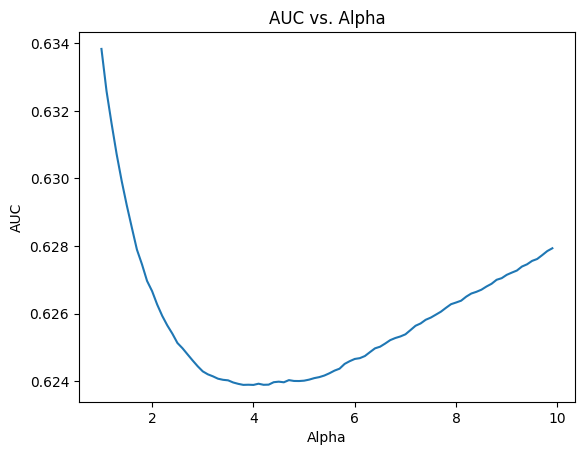

In [ ]:
from sklearn.naive_bayes import MultinomialNB

alpha_values = np.arange(1, 10, 0.1)
res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in alpha_values],
                index=alpha_values)
best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.7641
Accuracy: 99.86%


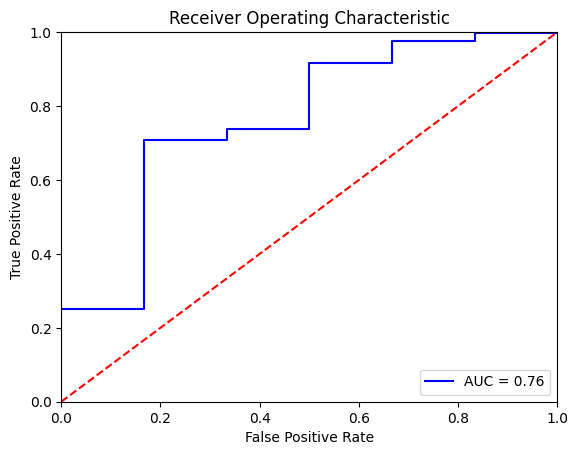

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

### fine-tuning BERT

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@')
    - Correct errors
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@'
    text = re.sub(r'(@.*?)[\s]',' ', text)

    # Replace '<\br>' with ' '
    text = re.sub(r'<\br>;', ' ', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  I had the most wonderful stay at Maud’s apartment!. All these plants instantly brought a sense of tranquility to the space. It created such a lovely atmosphere and made the place feel like a true oasis.<br/>The neighborhood itself had such a great vibe - laid-back, friendly, and filled with hidden gems. I enjoyed exploring the local cafes and bars.<br/>The kitchen was an absolute pleasure to cook in also. It was well-equipped with everything I needed to prepare my meals, and the layout was practical and convenient. <br/>I would highly recommend it to anyone looking for a peaceful and rejuvenating getaway in the middle of a busy city. I can't wait to come back!
Processed:  I had the most wonderful stay at Maud’s apartment!. All these plants instantly brought a sense of tranquility to the space. It created such a lovely atmosphere and made the place feel like a true oasis.<br/>The neighborhood itself had such a great vibe - laid-back, friendly, and filled with hidden gems. I e

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Concatenate train data and test data (test data is already a subset of train data)
all_data = data.review.values

# Encode our concatenated data
encoded_data = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Max length:  1021


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I had the most wonderful stay at Maud’s apartment!. All these plants instantly brought a sense of tranquility to the space. It created such a lovely atmosphere and made the place feel like a true oasis.<br/>The neighborhood itself had such a great vibe - laid-back, friendly, and filled with hidden gems. I enjoyed exploring the local cafes and bars.<br/>The kitchen was an absolute pleasure to cook in also. It was well-equipped with everything I needed to prepare my meals, and the layout was practical and convenient. <br/>I would highly recommend it to anyone looking for a peaceful and rejuvenating getaway in the middle of a busy city. I can't wait to come back!
Token IDs:  [101, 1045, 2018, 1996, 2087, 6919, 2994, 2012, 21696, 1521, 1055, 4545, 999, 1012, 2035, 2122, 4264, 6880, 2716, 1037, 3168, 1997, 25283, 26147, 3012, 2000, 1996, 2686, 1012, 2009, 2580, 2107, 1037, 8403, 7224, 1998, 2081, 1996, 2173, 2514, 2066, 1037, 2995, 18128, 1012, 1026, 7987, 1013, 1028, 1996, 5101,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 64 ms, sys: 3.08 ms, total: 67.1 ms
Wall time: 99.3 ms


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.101505   |     -      |     -     |   6.59   
   1    |   40    |   0.012489   |     -      |     -     |   6.16   
   1    |   60    |   0.021365   |     -      |     -     |   6.22   
   1    |   80    |   0.002581   |     -      |     -     |   6.27   
   1    |   100   |   0.011822   |     -      |     -     |   6.34   
   1    |   120   |   0.011839   |     -      |     -     |   6.35   
   1    |   140   |   0.001902   |     -      |     -     |   6.41   
   1    |   160   |   0.001471   |     -      |     -     |   6.49   
   1    |   180   |   0.001196   |     -      |     -     |   6.48   
   1    |   200   |   0.011655   |     -      |     -     |   6.41   
   1    |   220   |   0.001243   |     -      |     -     |   6.45   
   1    |   240   |   0.012051   |     -      |     -     |   6.48   


In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'bert_classifier' is not defined

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.107408   |     -      |     -     |   6.90   
   1    |   40    |   0.021288   |     -      |     -     |   6.78   
   1    |   60    |   0.012286   |     -      |     -     |   6.80   
   1    |   80    |   0.002431   |     -      |     -     |   6.81   
   1    |   100   |   0.011815   |     -      |     -     |   6.85   
   1    |   120   |   0.011677   |     -      |     -     |   6.82   
   1    |   140   |   0.001763   |     -      |     -     |   6.85   
   1    |   160   |   0.011791   |     -      |     -     |   6.86   
   1    |   180   |   0.011796   |     -      |     -     |   6.90   
   1    |   200   |   0.011880   |     -      |     -     |   6.89   
   1    |   220   |   0.022405   |     -      |     -     |   6.91   
   1    |   240   |   0.012045   |     -      |     -     |   6.91   


In [ ]:
test_data.sample(5)

,id,review
1001,32410156,"My mother said, “if you’ve got nothing nice to..."
626,39965746,"The apartment is clean, the radiators are plen..."
676,625924887219854517,kicked me out because i kept a plate for one n...
22,4472978,Apartment is exactly as described. It is very...
901,48214528,Host is nice and communication was OK. Expect ...


In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.999604  # manually adjusted to get predicted non-negative reviews = 300
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of reviews predicted non-negative
print("Number of reviews predicted non-negative: ", preds.sum())

Number of reviews predicted non-negative:  295


In [ ]:
output = test_data[preds==1]
list(output.sample(20).review)

['This is a great NY find. It is really near to the MTA and had access to the whole city. They building is run down NY but the room is clean and fine. It slept our family of 7 just fine. We would stay here again.',
 "Good location and quiet. Myriam she's kind and always helpful person; when ever we needed her, she was responding even late night",
 'AMAZING stay! This is our second time booking with Jose the host is super friendly and responsive,the place is always super clean and super comfortable. You get your own private bathroom as well which is very hard to find on bnb to begin with when booking private rooms along with a fully functioning shared kitchen and the neighborhood is very safe. Would recommend 1000%!',
 'We were in town for work and we were able to enjoy our stay. Working nights and sleeping in the day made being able to rest in the daytime very important. We enjoyed a quiet peaceful stay, thank you.',
 'Very clean/quiet place. The sheets were clean and did not have any 

In [ ]:
torch.save(bert_classifier, '/content/drive/MyDrive/Colab Notebooks/airbnBERT')

In [ ]:
saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/airbnBERT')

In [ ]:
saved_model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

### testing on standard BERT (not fine-tuned)

AUC: 0.6954
Accuracy: 0.28%


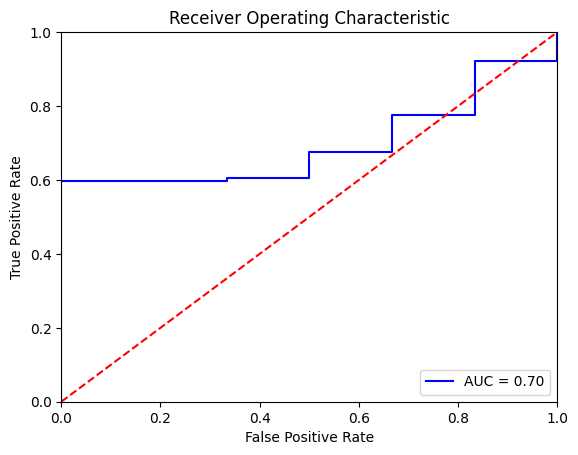

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)


# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.567  # manually adjusted to get predicted non-negative reviews = 300
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of reviews predicted non-negative
print("Number of reviews predicted non-negative: ", preds.sum())

Number of reviews predicted non-negative:  309


In [ ]:
output = test_data[preds==1]
list(output.sample(20).review)

['Terrible',
 'I wouldn’t recommend this stay if you have a sensitive nose or you’re not used to smokers. The minute you walk into the building it smells very strongly like cigars. Checkout is at noon, but for some reason someone entered at 9am the day before we were checking out. The host claims he thought we were checking out that day, which I understand, but at 9am? When check out is at noon. Doesn’t add up to me. The host was accommodating and let us check in 2 hours early.  Overall it looked like the picture, but I wouldn’t recommend due to privacy.',
 'Charming apt, Risha is a great host.',
 'Terrible communication and guest treatment',
 'The scenery is very nice and the room was awesome I really like how the pineapples was set up around the place.🤗',
 'This is a great place to stay. It was clean, felt like home, the host was very responsive when I had a question, and it was easy to find. I would gladly recommend this place to anyone. We enjoyed our stay',
 'X',
 'My planned 6-mo